# MODELING NOTEBOOK

This notebook contains the various models used for prediction using only the patient metadata. The most successful model will be used in the final model for mortality prediction, integrating probabilities from X-ray images as an additional feature.

Notebook outline:

<br>1) Load Packages
<br>2) Load cleaned data with pandas
<br>3) Identify Target and perform TTS
<br>4) Baseline dummy classifier and defining functions
<br>5) Logistic Regression modeling and hyperparameter tuning with GridSearchCV
<br>6) Penalized SVC model for target class imbalance and SMOTE oversampling
<br>7) K-Nearest Neighbors classifier and hyperparameter tuning
<br>8) Gradient Booster Classifier modeling
<br>9) XGBoost Classifier modeling
<br>10) Random Forest classifier modeling
<br>11) Summary

## 1) Load Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

## 2) Load cleaned data with pandas

In [2]:
df = pd.read_csv('Data/df.csv')
df.head()

,patient_id,last.status,is_icu,length_of_stay,days_prior_sx,8331-1_Oral temperature,59408-5_Oxygen saturation in Arterial blood by Pulse oximetry,9279-1_Respiratory rate,76282-3_Heart rate.beat-to-beat by EKG,8480-6_Systolic blood pressure,...,x7_False,x7_True,x8_False,x8_True,x9_False,x9_True,x10_False,x10_True,x11_False,x11_True
0,A917122,discharged,0.0,9.0,10.6,36.4,91.0,22.0,86.0,172.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,A387558,deceased,1.0,15.0,4.2,37.0,100.0,39.0,149.0,158.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2,A968238,deceased,1.0,28.0,4.0,37.4,84.0,42.0,88.0,130.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,A106133,deceased,0.0,4.0,6.0,36.7,96.0,16.0,100.0,132.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
4,A300871,deceased,0.0,3.0,6.0,36.7,97.0,20.0,94.0,104.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


## 3) Identify Target and perform TTS

In [3]:
X = df.drop(labels=['last.status'], axis=1)
mapping = {'discharged':1, 'deceased':0}
y = df['last.status'].replace(mapping)

In [4]:
df['last.status'].value_counts()

discharged    1178
deceased       135
Name: last.status, dtype: int64

In [5]:
X.set_index('patient_id', inplace=True)
X.head()

,is_icu,length_of_stay,days_prior_sx,8331-1_Oral temperature,59408-5_Oxygen saturation in Arterial blood by Pulse oximetry,9279-1_Respiratory rate,76282-3_Heart rate.beat-to-beat by EKG,8480-6_Systolic blood pressure,76536-2_Mean blood pressure by Noninvasive,33256-9_Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count,...,x7_False,x7_True,x8_False,x8_True,x9_False,x9_True,x10_False,x10_True,x11_False,x11_True
patient_id,,,,,,,,,,,,,,,,,,,,,
A917122,0.0,9.0,10.6,36.4,91.0,22.0,86.0,172.0,91.0,9.380,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
A387558,1.0,15.0,4.2,37.0,100.0,39.0,149.0,158.0,109.0,25.190,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
A968238,1.0,28.0,4.0,37.4,84.0,42.0,88.0,130.0,93.0,9.110,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
A106133,0.0,4.0,6.0,36.7,96.0,16.0,100.0,132.0,71.0,6.060,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
A300871,0.0,3.0,6.0,36.7,97.0,20.0,94.0,104.0,99.0,5.808,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [6]:
X.columns

Index(['is_icu', 'length_of_stay', 'days_prior_sx', '8331-1_Oral temperature',
       '59408-5_Oxygen saturation in Arterial blood by Pulse oximetry',
       '9279-1_Respiratory rate', '76282-3_Heart rate.beat-to-beat by EKG',
       '8480-6_Systolic blood pressure',
       '76536-2_Mean blood pressure by Noninvasive',
       '33256-9_Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count',
       '751-8_Neutrophils [#/volume] in Blood by Automated count',
       '731-0_Lymphocytes [#/volume] in Blood by Automated count',
       '2951-2_Sodium [Moles/volume] in Serum or Plasma',
       '1920-8_Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
       '1744-2_Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5'-P',
       '2524-7_Lactate [Moles/volume] in Serum or Plasma',
       '6598-7_Troponin T.cardiac [Mass/volume] in Serum or Plasma',
       '33762-6_Natriuretic peptide.B prohormone 

### Renaming a column to perform StandardScaler transformation

In [7]:
#rename alaine col to remove ', causes error in StandardScaler
X.columns[14]

"1744-2_Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5'-P"

In [8]:
X.rename(columns={X.columns[14]: "1744-2_Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5-P"}, 
         inplace=True)

In [9]:
#rename check
X.columns

Index(['is_icu', 'length_of_stay', 'days_prior_sx', '8331-1_Oral temperature',
       '59408-5_Oxygen saturation in Arterial blood by Pulse oximetry',
       '9279-1_Respiratory rate', '76282-3_Heart rate.beat-to-beat by EKG',
       '8480-6_Systolic blood pressure',
       '76536-2_Mean blood pressure by Noninvasive',
       '33256-9_Leukocytes [#/volume] corrected for nucleated erythrocytes in Blood by Automated count',
       '751-8_Neutrophils [#/volume] in Blood by Automated count',
       '731-0_Lymphocytes [#/volume] in Blood by Automated count',
       '2951-2_Sodium [Moles/volume] in Serum or Plasma',
       '1920-8_Aspartate aminotransferase [Enzymatic activity/volume] in Serum or Plasma',
       '1744-2_Alanine aminotransferase [Enzymatic activity/volume] in Serum or Plasma by No addition of P-5-P',
       '2524-7_Lactate [Moles/volume] in Serum or Plasma',
       '6598-7_Troponin T.cardiac [Mass/volume] in Serum or Plasma',
       '33762-6_Natriuretic peptide.B prohormone N

In [10]:
#Train test split of data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [11]:
#attempt to scale the data w/ standardscaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
X_train_scaled

array([[-0.44143042, -0.70353762,  0.491281  , ..., -0.73871941,
         0.63404262, -0.63404262],
       [-0.44143042, -0.53560949,  0.0302403 , ...,  1.35369395,
         0.63404262, -0.63404262],
       [-0.44143042,  0.22006711,  2.33544379, ..., -0.73871941,
         0.63404262, -0.63404262],
       ...,
       [-0.44143042, -0.70353762,  0.72180135, ...,  1.35369395,
         0.63404262, -0.63404262],
       [-0.44143042,  0.72385151,  0.0302403 , ..., -0.73871941,
        -1.57718103,  1.57718103],
       [-0.44143042, -0.70353762, -0.06196784, ...,  1.35369395,
         0.63404262, -0.63404262]])

## 4) Baseline dummy classifier and defining functions

### Dummy classifier baseline model

In [13]:
#creation of baseline model with dummy classifier



dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_scaled, y_train)
dummy.score(X_test_scaled, y_test)

0.9137055837563451

### Functions for plots and metrics

In [14]:
def metrics_crossval_score(model, X_train, X_test, y_train, y_test, y_pred):
    train = cross_val_score(model, X_train, y_train, cv=5).mean()
    test = cross_val_score(model, X_test, y_test, cv=5).mean()
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    return ("Training set score:", train), ("Test set score:", test), ('Accuracy:', acc), ('F1 score:', f1), ('Precision:', prec)



In [15]:
def plot_matrix(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    
    return sns.heatmap(matrix, annot=True, cmap='BuPu', fmt='.4g', xticklabels=['Deceased', 'Discharged'], 
                       yticklabels=['Deceased', 'Discharged']), plt.yticks(rotation=0)

## 5) LOGISTIC REGRESSION MODELING

In [16]:
#create logistic regression model, fit to training data and score on test data

lr = LogisticRegression(random_state=42, max_iter=10000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
lr.score(X_test_scaled, y_test)

0.8984771573604061

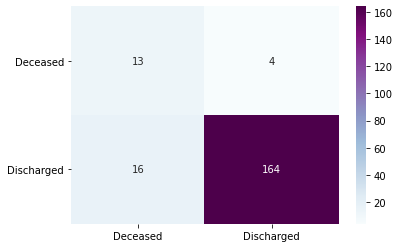

In [17]:
#confusion matrix of lr model
plot_matrix(y_test, y_pred);


In [18]:
metrics_crossval_score(lr, X_train_scaled, X_test_scaled, y_train, y_test, y_pred)

(('Training set score:', 0.9050248238308777),
 ('Test set score:', 0.8429487179487181),
 ('Accuracy:', 0.8984771573604061),
 ('F1 score:', 0.9425287356321839),
 ('Precision:', 0.9761904761904762))

In [19]:
y_test.value_counts()

1    180
0     17
Name: last.status, dtype: int64

### Insight: This model is overfitting to the training data and there is a class imbalance in the target. The test size will be increased and gridscarchCV will be used to tune hyperparameters. If this doesn't improve performance, the dataset can be resampled to address the imbalance using SMOTE.

**Can GridSearchCV improve modeling scores??**

In [20]:
# #Optimized grid search parameters are used in the lr2 model, so this section is commented to decrease processing time

param_grid = {'penalty':['l2', 'l1','elasticnet'],
             'max_iter':[1000, 10000, 100000]}


Grid = GridSearchCV(estimator=lr, param_grid=param_grid)
Grid.fit(X_train_scaled, y_train)

GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=42),
             param_grid={'max_iter': [1000, 10000, 100000],
                         'penalty': ['l2', 'l1', 'elasticnet']})

In [21]:
Grid.best_params_

{'max_iter': 1000, 'penalty': 'l2'}

### increasing test size for more accurate predictions

In [22]:
# will increasing the test size improve the model and help overfitting?

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.30, random_state=42)

scaler2 = StandardScaler().fit(X_train2)
X_train2_scaled = scaler2.transform(X_train2)
X_test2_scaled = scaler2.transform(X_test2)

lr2 = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr2.fit(X_train2_scaled, y_train2)
y_pred2 = lr2.predict(X_test2_scaled)
lr2.score(X_test2_scaled, y_test2)

0.8959390862944162

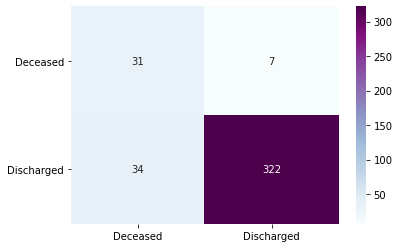

In [23]:
plot_matrix(y_test2, y_pred2);


In [24]:
metrics_crossval_score(lr2, X_train2_scaled, X_test2_scaled, y_train2, y_test2, y_pred2)

(('Training set score:', 0.9031895937277262),
 ('Test set score:', 0.8833495618305746),
 ('Accuracy:', 0.8959390862944162),
 ('F1 score:', 0.9401459854014599),
 ('Precision:', 0.9787234042553191))

In [25]:
y_test2.value_counts()

1    356
0     38
Name: last.status, dtype: int64

### Insight: increasing the test size improves model performance, but the model still doesn't predict well. Will oversample the minority class (deceased/0) and re-evaluate the model.

## 6) Penalized SVC model for target class imbalance and SMOTE oversampling

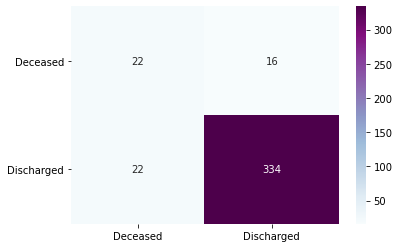

In [26]:
#try: SMOTE, penalized-SVM



svc = SVC(class_weight='balanced', probability=True)
svc.fit(X_train2_scaled, y_train2)
svc_pred = svc.predict(X_test2_scaled)
plot_matrix(y_test2, svc_pred);

In [27]:
metrics_crossval_score(svc, X_train2_scaled, X_test2_scaled, y_train2, y_test2, svc_pred)

(('Training set score:', 0.9140472796388691),
 ('Test set score:', 0.8909120415449531),
 ('Accuracy:', 0.9035532994923858),
 ('F1 score:', 0.9461756373937678),
 ('Precision:', 0.9542857142857143))

In [28]:
#SMOTE of target variable



smote=SMOTE()

x_train_smote, y_train_smote = smote.fit_resample(X_train2_scaled, y_train2)


print('Original dataset shape', y_train2.value_counts())
print('Resample dataset shape', y_train_smote.value_counts())

Original dataset shape 1    822
0     97
Name: last.status, dtype: int64
Resample dataset shape 1    822
0    822
Name: last.status, dtype: int64


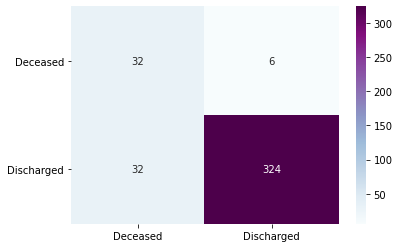

In [29]:
#logreg model with smote variables

lr3 = LogisticRegression(random_state=42, max_iter=1000)
lr3.fit(x_train_smote, y_train_smote)
lr3_pred = lr3.predict(X_test2_scaled)
plot_matrix(y_test2, lr3_pred);

In [30]:
metrics_crossval_score(lr3, x_train_smote, X_test2_scaled, y_train_smote, y_test2, lr3_pred)

(('Training set score:', 0.9416190970420342),
 ('Test set score:', 0.8985069782538139),
 ('Accuracy:', 0.9035532994923858),
 ('F1 score:', 0.9446064139941691),
 ('Precision:', 0.9818181818181818))

### Insight: using SMOTE modified sets did not improve model predictions and increased false positives. Will continue to use scaled data in subsequent models.

#### Can KNN do a better job at prediction?

## 7) K Nearest Neighbors Classifier modeling

In [31]:
#KNN attempt


knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train2_scaled, y_train2)
y_pred_knn = knn.predict(X_test2_scaled)
knn.score(X_test2_scaled, y_test2)

0.9111675126903553

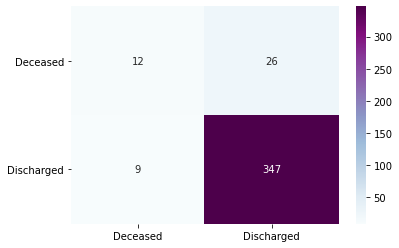

In [32]:
plot_matrix(y_test2, y_pred_knn);


In [33]:
#Gridsearch commented out, best params are used in knn2 model

knn_params = {'n_neighbors': list(range(1, 29, 2)),
       'metric': ['euclidean', 'manhattan', 'minkowski']}

knn_grid = GridSearchCV(estimator=knn, param_grid=knn_params)
knn_grid.fit(X_train2_scaled, y_train2)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27]})

In [34]:
knn_grid.best_params_

{'metric': 'euclidean', 'n_neighbors': 13}

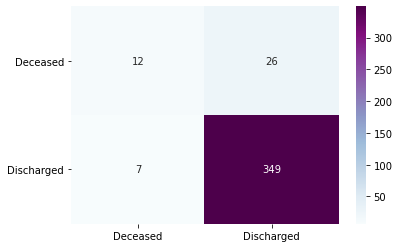

In [35]:
knn2 = KNeighborsClassifier(n_neighbors=13, metric='euclidean')

knn2.fit(X_train2_scaled, y_train2)
knn_pred2 = knn2.predict(X_test2_scaled)
plot_matrix(y_test2, knn_pred2);


In [36]:
metrics_crossval_score(knn2, X_train2_scaled, X_test2_scaled, y_train2, y_test2, knn_pred2)

(('Training set score:', 0.9270729389403659),
 ('Test set score:', 0.9036027263875365),
 ('Accuracy:', 0.916243654822335),
 ('F1 score:', 0.9548563611491109),
 ('Precision:', 0.9306666666666666))

### Insight: This model minimizes false positive/discharged predictions and is well fit to the data for both train and test. Can another model perform better?

## 8) GradientBoostingClassifier modeling

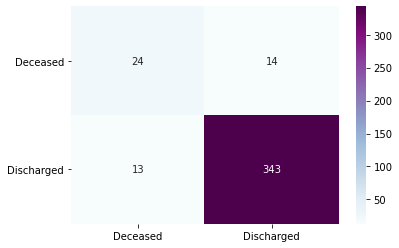

In [37]:
#GradientBoosting attempt and plot confusion matrix


GBC = GradientBoostingClassifier()
GBC.fit(X_train2_scaled, y_train2)
gbc_pred = GBC.predict(X_test2_scaled)
plot_matrix(y_test2, gbc_pred);

In [38]:
#crossval score and metrics for GB model
metrics_crossval_score(GBC, X_train2_scaled, X_test2_scaled, y_train2, y_test2, gbc_pred)

(('Training set score:', 0.9270848182466145),
 ('Test set score:', 0.8934436871145733),
 ('Accuracy:', 0.9314720812182741),
 ('F1 score:', 0.9621318373071528),
 ('Precision:', 0.9607843137254902))

### Insight: GB classifier works better than previous models but has more false positives than KNN. Can gridsearch optimize further?

In [39]:
#gridsearch is commented out due to extended runtime(> 1hr). The optimized parameters are used in the GBC2 model

# gbc_params = {'loss':['deviance', 'exponential'], 'learning_rate':[0.01, 0.1, 0.5, 1.0], 
#             'n_estimators':[100, 1000, 5000, 10000]}

# gbc_grid = GridSearchCV(estimator=GBC, param_grid=gbc_params)
# gbc_grid.fit(X_train2_scaled, y_train2)

In [40]:
# gbc_grid.best_params_

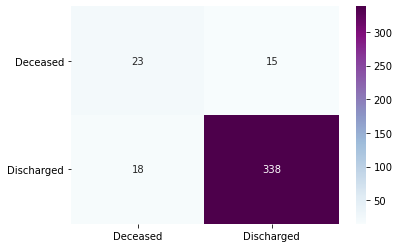

In [41]:
#Gradient booster classifier with best gridsearch params

GBC2 = GradientBoostingClassifier(loss='exponential', learning_rate=1.0, n_estimators=10000)
GBC2.fit(X_train2_scaled, y_train2)
gbc2_pred = GBC2.predict(X_test2_scaled)
plot_matrix(y_test2, gbc2_pred);

In [42]:
metrics_crossval_score(GBC2, X_train2_scaled, X_test2_scaled, y_train2, y_test2, gbc2_pred)

(('Training set score:', 0.9292706105963411),
 ('Test set score:', 0.8858487504057123),
 ('Accuracy:', 0.916243654822335),
 ('F1 score:', 0.9534555712270804),
 ('Precision:', 0.9575070821529745))

### Insight: Paradoxically, the optimized parameters actually result in a WORSE model.

## 9) XGBoost Classifier modeling

#### removing characters from feature names for XGBoost classifier

In [43]:


regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train2.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train2.columns.values]

In [44]:
X_test2.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test2.columns.values]

In [45]:
mapper = {'x0_(59,74]':'Age_59-74' ,'x0_(74,90]':'Age_74-90' , 'x0_[18,59]':'Age_18-59'}

X_train2_mod = X_train2.rename(mapper=mapper, axis=1)
X_test2_mod = X_test2.rename(mapper=mapper, axis=1)

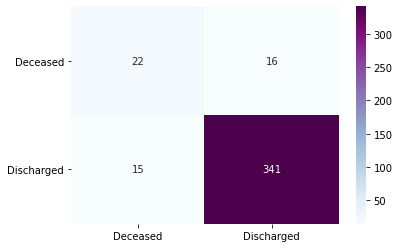

In [46]:
#attempting XGBoost classifier


xgb = XGBClassifier()

xgb.fit(X_train2, y_train2)
xgb_pred = xgb.predict(X_test2)
plot_matrix(y_test2, xgb_pred);

In [47]:
metrics_crossval_score(xgb, X_train2, X_test2, y_train2, y_test2, xgb_pred)

(('Training set score:', 0.9238239486813971),
 ('Test set score:', 0.9036027263875365),
 ('Accuracy:', 0.9213197969543148),
 ('F1 score:', 0.9565217391304349),
 ('Precision:', 0.9551820728291317))

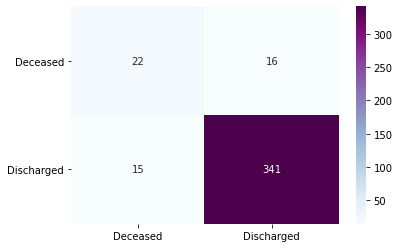

In [48]:

xgb = XGBClassifier()

xgb.fit(X_train2_mod, y_train2)
xgb_pred = xgb.predict(X_test2_mod)
plot_matrix(y_test2, xgb_pred);

### While XGBoost has higher metrics than KNN, it also increases false positives, which must be minimized in our models.

## 10) Random Forest Classifier modeling

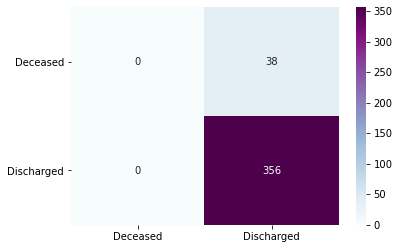

In [49]:
#instantiate classifier, fit to train and predict on test

rf = RandomForestClassifier()
rf.fit(X_train2_scaled, y_train2)
y_pred_rf = rf.predict(X_test2)
plot_matrix(y_test2, y_pred_rf);

In [50]:
#hyperparameter tuning with gridsearchcv

rf_grid = {'n_estimators':[100, 200, 500, 1000], 'criterion':['gini', 'entropy'],
          'class_weight':['balanced', 'balanced_subsample']}

rfGrid = GridSearchCV(estimator=rf, param_grid=rf_grid)
rfGrid.fit(X_train2_scaled, y_train2)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 200, 500, 1000]})

In [51]:
rfGrid.best_params_

{'class_weight': 'balanced', 'criterion': 'entropy', 'n_estimators': 200}

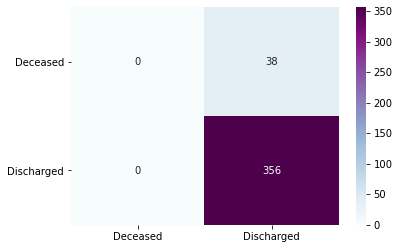

In [52]:
rf2 = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', criterion='entropy')
rf2.fit(X_train2_scaled, y_train2)
y_pred2_rf = rf2.predict(X_test2)
plot_matrix(y_test2, y_pred2_rf);

### The Random forest classifier fails, as it is behaving exactly the same as the dummy classifier despite tuning hyper parameters.

## 11) Summary:
It appears that the knn2 model is the best performing model for mortality prediction. The training data fits well and the false positives are the lowest of all models attempted. This model will be used in the final modeling notebook to make mortality predictions with patient data and predictions from the CNN model.